# Yelp Data Challenge - Topic Discovery Among Reviews
Restaurant owners would probably like to get a better understanding of diners, and data scientists can help by clustering (vectorizer) restaurant reviews. Here we utilize K-means clustering to discover
- the cuisines commonly reviewed in Las Vegas
- the concerns that diners commonly share

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [5]:
df = pd.read_csv('data/last_2_years_restaurant_reviews.csv')
df.head(3)

,business_id,name,categories,avg_stars,attributes,cool,date,funny,review_id,stars,text,useful,user_id
0,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2017-04-01,0,Spl0fx_X6bjPASU-zUJQUA,1,"Ordered a pizza, the location is literally in ...",1,vZ-eQzpCOrSWfBfU5KUvIA
1,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2016-11-20,0,2UV-a8pXUdbK0fdurFwXfQ,5,Very busy place but they take good care of you...,0,nu6wU6PLbL9HPLZuqon0-A
2,2kWrSFkIes_d2BMg4YrRtA,Pizza Hut,"Restaurants, Pizza",2.5,"{'Alcohol': 'none', 'Ambience': ""{'romantic': ...",0,2018-03-27,0,vG5m3TzOf5F52jzO2D_19g,3,Stopped here to pick up an order of wings on m...,0,KEerqlFNhzl1I-yVK6mHVA


In [6]:
# Minor number of NAs in 'attributes'; fortunately, we won't need that feature
pd.DataFrame.sum(df.isna())

business_id     0
name            0
categories      0
avg_stars       0
attributes     84
cool            0
date            0
funny           0
review_id       0
stars           0
text            0
useful          0
user_id         0
dtype: int64

In [7]:
# Take the values of the column that contains review text data, save to a variable named "documents"
documents = df.text

In [8]:
# The number of reviews
print(documents.shape)

(101569,)


## Splitting into training and test sets

We can simulate the influx of new data by creating a held-out "test set". K-means clustering is of course unsupervised; we are just borrowing terminology from supervised methods.

In [9]:
from sklearn.model_selection import train_test_split

documents_train, documents_test = train_test_split(documents, test_size=0.20, random_state=49)

## Data-driven discovery of stop words
For this exercise we will consider unigrams and bigrams only. We will plot their frequency distribution, and experiment with various cutoffs for rejecting tokens. In particular, we want to filter out words that are
1. so common that they contain little specific information
2. so infrequent that they describe specific niche situations.

To accomplish the goals above, two successive steps are taken:
1. Filter tokens with too small/big a document-frequency.
2. Then, count the remaining tokens, and determine additional thresholds on *corpus-wide* term frequencies

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
# First filter by DF: note the arguments fed into CountVectorizer
# To reiterate: we have ~100,000 reviews. 1% of that is 1000 reviews, reasonable min_df?

count_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=0.01, max_df=0.95)
token_counts = count_vectorizer.fit_transform(documents_train)

In [13]:
# Turn into numpy arrays for boolean masking later
unigram_indices = np.asarray([ix for token,ix in count_vectorizer.vocabulary_.items() \
                              if len(token.split())==1])

bigram_indices = np.asarray([ix for token,ix in count_vectorizer.vocabulary_.items()\
                             if len(token.split())==2])

In [14]:
# CORPUS-WIDE term frequency; take log10 to compress the range
unigram_tf = np.log10( np.sum(token_counts[:, unigram_indices], axis=0) )
bigram_tf = np.log10( np.sum(token_counts[:, bigram_indices], axis=0) )

# Without these two lines, plotting cumulative frequencies would take forever
unigram_tf = np.asarray(unigram_tf).reshape(-1)
bigram_tf = np.asarray(bigram_tf).reshape(-1)

Text(0.5, 1.0, 'Bigram Distribution')

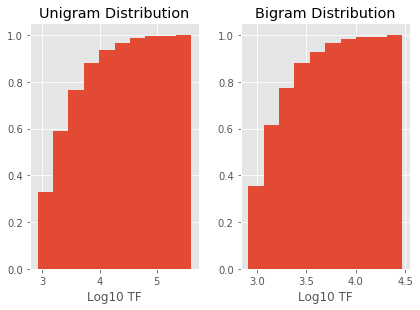

In [15]:
# Cumulative frequency plot of corpus-wide TF
# Rather arbitarily, we will remove tokens beyond 0.9; will validate results manually below

fig, axes = plt.subplots(1,2)
plt.tight_layout()
axes[0].hist(unigram_tf, bins=10, cumulative=True, density=True)
axes[1].hist(bigram_tf, bins=10, cumulative=True, density=True)

axes[0].set_xlabel("Log10 TF")
axes[1].set_xlabel("Log10 TF")

axes[0].set_title("Unigram Distribution")
axes[1].set_title("Bigram Distribution")

### Filter and validate!

In [16]:
# Create index-to-string lookup table; so that we know which tokens are filtered out
ix_to_token = {ix:token for token,ix in count_vectorizer.vocabulary_.items()}

In [17]:
# Thresholds of 4.x and ~3.x eyeballed from cumulative frequency graphs
# Tried a few near values to optimize results --- e.g. so that no tokens describing
# specific food items are included in the 'drop list'

# As seen below, vast majority of unigrams and bigrams filtered out are grammatical constructs 
# without much semantic meaning on their own --- 'so', 'the', 'not', 'from', 'in/of the' etc.
# There are also food-related terms that we can safely assume to be so common in restaurant
# reviews that they can be ignored: 'food', 'menu', 'the menu', 'in vegas' etc

unigrams_to_drop_ix = unigram_indices[unigram_tf > 4.2]
bigrams_to_drop_ix = bigram_indices[bigram_tf > 3.7]

excess_unigrams = set([ix_to_token[ix] for ix in unigrams_to_drop_ix])
excess_bigrams = set([ix_to_token[ix] for ix in bigrams_to_drop_ix])

print(excess_unigrams)
print(excess_bigrams)

{'so', 'time', 'our', 'or', 'the', 'with', 'get', 'you', 'order', 'had', 'really', 'not', 'in', 'from', 'was', 'also', 'vegas', 'they', 'great', 'but', 'can', 'their', 'all', 'to', 'restaurant', 'go', 'ordered', 'are', 'we', 'of', 'is', 'here', 'me', 'will', 'on', 'out', 'us', 'back', 'when', 'that', 'which', 'my', 'it', 'at', 'good', 'there', 'for', 'as', 'were', 'service', 'very', 'just', 'would', 'have', 'one', 'be', 'this', 'place', 'like', 'if', 'and', 'up', 'food'}
{'as well', 'it was', 'and it', 'this place', 'service was', 'was very', 'on the', 'from the', 'the service', 'all the', 'the food', 'but the', 'was great', 'food and', 'we were', 'for the', 'place is', 'we had', 'had the', 'in vegas', 'was good', 'they have', 'if you', 'to get', 'and they', 'food was', 'was the', 'to be', 'this is', 'but it', 'be back', 'is the', 'to go', 'the restaurant', 'had to', 'the menu', 'with the', 'and we', 'they were', 'at the', 'food is', 'the best', 'ordered the', 'it is', 'was so', 'to th

In [18]:
final_vocab = [token for token in count_vectorizer.vocabulary_.keys() 
               if (token not in excess_bigrams) and (token not in excess_unigrams)]

## Obtain TF-IDF representation of `documents`

Consider only unigrams + bigrams, and obtain Tf-Idf vectors of `documents`. 

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
# Create TfidfVectorizer, and name it vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),
                                   vocabulary=final_vocab)

In [21]:
# Fit the vectorizer with training data
vec_doc_train = tfidf_vectorizer.fit_transform(documents_train)

# Transform all data together
vec_doc_all = tfidf_vectorizer.transform(documents)

In [22]:
# Now that vectorizer is fitted, Get the vocab of your tfidf
# vectorizer.vocabulary_ records feature indices!
token_to_index = tfidf_vectorizer.vocabulary_

# Reverse dictionary for interpreting results
index_to_token = {index:token for token,index in token_to_index.items()}

print("Vocabulary contains {} items".format(len(tfidf_vectorizer.vocabulary_)))

Vocabulary contains 1536 items


## Finally, cluster reviews with KMeans
Fit k-means clustering with "training data", and then apply it on the entire data set. Tune with the elbow method.

In [23]:
# Using sklearn.cluster.MiniBatchKMeans instead of sklearn.cluster.KMeans
# Slightly worse clustering maybe? But much faster convergence

from sklearn.cluster import MiniBatchKMeans

In [24]:
# Define function for printing top features of each cluster
# 'Top features' being the largest components of the centroid vector 
# Remember: TF-IDF vector components are always non-negative, so we don't have to worry about sign

def print_top_features(kmeans_obj, ix_to_tokens, n=10):
    '''
        Reveals the 'most important' tokens in each KMeans cluster
        
        Args:
            kmeans_obj: fitted sklearn.cluster.MiniBatchKMeans() or KMeans() object
            ix_to_tokens: dictionary mapping feature indices to string token
            n: integer number of top tokens to display
    '''
    cluster_centers = kmeans_obj.cluster_centers_
    labels = kmeans_obj.labels_
    
    for i, centroid in enumerate(cluster_centers):
        top_n_features = np.argsort(centroid)[::-1]
        top_n_features = top_n_features[:n]
        top_n_words = [ix_to_tokens[feature_index] for feature_index in top_n_features]

        print("Top tokens from cluster {} (# of obs: {})".format(i, (labels==i).sum()))
        print(top_n_words)

In [25]:
# Start with arbitrary K = 3, as a trial
kmeans = MiniBatchKMeans(n_clusters=3, batch_size=500, max_iter=1000, n_init=5)
kmeans.fit(vec_doc_all)
print_top_features(kmeans, index_to_token, n=10)

Top tokens from cluster 0 (# of obs: 34861)
['amazing', 'best', 'delicious', 'love', 'friendly', 'staff', 'definitely', 'always', 'recommend', 'excellent']
Top tokens from cluster 1 (# of obs: 21855)
['he', 'she', 'been', 'no', 'never', 'about', 'her', 'even', 'came', 'because']
Top tokens from cluster 2 (# of obs: 44853)
['chicken', 'too', 'pizza', 'got', 'more', 'only', 'little', 'your', 'some', 'don']


### Experiment with different K

Attempt to find optimal K's using elbow method. Also tried silhouette score, but computations on a representative sample takes far too long. Elbow method it is!

In [39]:
# from sklearn.metrics import silhouette_score
import elbow

Text(0, 0.5, 'Mean Intra-cluster SS')

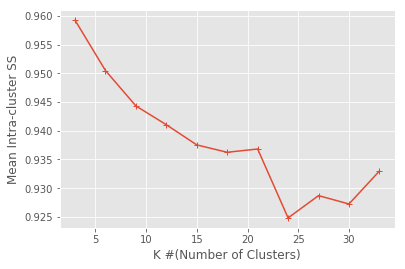

In [42]:
k_to_try = range(3, 34, 3)
intra_cluster_ss = elbow.elbow_tuner(vec_doc_train, k_to_try)
plt.plot(k_to_try, intra_cluster_ss, '-+')
plt.xlabel('K #(Number of Clusters)')
plt.ylabel('Mean Intra-cluster SS')

In [45]:
'''
    Take first elbow at around K=17; tried values larger than 25, 
    but that gives multiple clusters that contain only one obseration.
    Finally, print top 8 features related to each cluster
'''

kmeans_final = MiniBatchKMeans(n_clusters=17, n_init=5).fit(vec_doc_all)
print_top_features(kmeans_final, index_to_token, n=8)

Top tokens from cluster 0 (# of obs: 3450)
['pho', 'ramen', 'broth', 'pork', 'noodles', 'the broth', 'bowl', 'the pork']
Top tokens from cluster 1 (# of obs: 6965)
['chicken', 'rice', 'the chicken', 'fried', 'thai', 'fried rice', 'curry', 'chicken and']
Top tokens from cluster 2 (# of obs: 2832)
['favorite', 'my favorite', 'always', 'of my', 'is my', 'love', 'delicious', 'amazing']
Top tokens from cluster 3 (# of obs: 2129)
['loved', 'loved the', 'loved it', 'definitely', 'delicious', 'amazing', 'everything', 'friendly']
Top tokens from cluster 4 (# of obs: 24940)
['delicious', 'burger', 'fries', 'nice', 'try', 'excellent', 'cheese', 'too']
Top tokens from cluster 5 (# of obs: 21565)
['she', 'he', 'no', 'about', 'what', 'because', 'even', 'didn']
Top tokens from cluster 6 (# of obs: 2496)
['highly', 'highly recommend', 'recommend', 'recommend this', 'delicious', 'recommend the', 'amazing', 'best']
Top tokens from cluster 7 (# of obs: 4557)
['pizza', 'the pizza', 'pizza was', 'pizza and

## Summary and Observations

### Popular Categories of Food
(Vietnamese) pho noodles, (Japanese) ramen, sushi, pizzas, Thai curry and fried rice all have their place in Las Vegas. However, it is burgers and fries (cluster 4) that seem to be overwhelmingly popular. The 'ethnic' food clusters each contain a few thousand review, while the burger cluster (#4) contain 24940 reviews. Recall that we have ~100,000 reviews in total!

Since it is highly unlikely that a restaurant would serve mutliple cuisines, we can assume that the there is minimal overlap in content among these 'cusine clusters'.

### Items of Attention for Restaurants
In case it isn't crystal clear, the **taste** of food matters --- as shown by the recurrence of 'delicious' in five different clusters. It is also vital to have **friendly staff** (clusters 3,8,10,14).
Last but not least, (maybe depending on the cusine) the restaurant's **atmosphere** and price play a role, too. See clusters 10 and 16.

On the other hand, as shown in `Preprocessing.ipynb`, most reviews gave 3 stars or above. Therefore it is no wonder that we hardly see tokens representing negative sentiment here. To put culinary pitfalls into focus, we must analyze the bad reviews separately.

### Further Refinement of Analysis Technique?
While including bigrams help, the analysis is hampered by tokens that contain repetitive information. For instance in cluster 6, we have ('highly recommend', 'recommend', 'recommend this'), which could even be different parts of the same sentence, overlapping at 'recommend'. 

To reduce the aforementioned 'noise', a better phrase-detection method is called for. This [blog post by Git(Hub) data scientist Kavita Ganesan](http://kavita-ganesan.com/how-to-incorporate-phrases-into-word2vec-a-text-mining-approach/#.WuiiKtMvyds) may contain some clues, but in the interest of time I will stop here for now.

A more esoteric concern is that clustering results may be quantitatively mediocre. Since scikit-learn's TfidfVectorizer normalizes the L2 norm of each observation to unit length, a mean squared centroid-observation distance of 0.9x implies that *some* clusters may overlap quite a bit in the hypersphere.

Could this a manifestation of the dimensionality curse? We do have 15xx features after all. Maybe we can apply PCA first, then cluster and attempt to discover themes? Will leave this for the next iteration of notebook.